# Mendelian diseases genomic regions analysis

Reference Genome: 

Mendelian Diseases positions:

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gc

## Auxiliar Fxns

In [2]:
def plot_region_counts(chromosome: str, counts: dict) -> plt.figure:
    labels = counts.keys()
    sizes = counts.values()
    colors = cm.tab10.colors 
    fig, ax = plt.subplots()
    ax.pie(
        sizes,
        labels= labels,
        colors= colors,
        autopct= '%1.1f%%',
        startangle= 90
    )
    ax.set_title(f'Chromosome {chromosome}')
    return fig

def load_gff(file_path: str) -> pd.DataFrame:
    columns = ["seqnames", "feature", "starts", "ends"]
    return pd.read_csv(
        filepath_or_buffer= file_path,
        names= columns,
        header= None,
        sep= '\t',
        comment= '#'
    )

def load_vcf(file_path: str) -> pd.DataFrame:
    columns = ["seqnames", "pos", "id", 'REF', 'ALT']
    return pd.read_csv(
        filepath_or_buffer= file_path,
        names= columns,
        header= None,
        sep= '\t',
        comment= '#',
        dtype= {
            'seqnames': 'string',
            'pos': 'int64',
            'id': 'int64',
            'REF': 'string',
            'ALT' : 'string'
        }
    )

def binary_search(pos: int, genome_regions: pd.DataFrame) -> str:
    search_pool = pd.Index(genome_regions)
    i = 0
    f = len(search_pool) - 1
    while i <= f:
        m = (i + f) // 2
        if pos >= search_pool[m][2] and pos <= search_pool[m][3]:
            return search_pool[m][1]
        elif pos > search_pool[m][3]: #Means its in right region of genome
            i = m + 1
        else:
            f = m - 1
    return 'unmapped'

def get_intergenic_regions(genes_df: pd.DataFrame) -> pd.DataFrame:
    individual_intergenic_regions = []
    for i in range(1, len(genes_df)):
        if genes_df.iloc[i]["seqnames"] == genes_df.iloc[i-1]["seqnames"]:
            intergenic = {
                "seqnames": genes_df.iloc[i - 1]["seqnames"],
                "starts": genes_df.iloc[i - 1]["ends"] + 1,
                "ends": genes_df.iloc[i]["starts"] - 1,
                "feature": "intergenic"
            }
            if intergenic['ends'] >= intergenic['starts']:
                individual_intergenic_regions.append(intergenic)

    intergenic_regions = {
        'seqnames' : [],
        'feature' : [],
        'starts' : [],
        'ends' : []
    }
    for intergen_region in individual_intergenic_regions:
        for feature, value in intergen_region.items():
            intergenic_regions[feature].append(value)
    
    return pd.DataFrame(intergenic_regions)

def get_intron_regions(coding_df: pd.DataFrame) -> pd.DataFrame:
    individual_intronic_regions = []

    for i in range(len(coding_df) - 1):
        if coding_df.iloc[i]["feature"] == 'gene' or coding_df.iloc[i]["feature"] == 'exon' or coding_df.iloc[i]["feature"] == 'CDS':
            if coding_df.iloc[i + 1]["feature"] == 'exon' or coding_df.iloc[i + 1]["feature"] == 'CDS' or coding_df.iloc[i + 1]["feature"] == 'intergenic':
                if coding_df.iloc[i + 1]['starts'] > coding_df.iloc[i]['ends']:
                    intronic = {
                        "seqnames": coding_df.iloc[i]['seqnames'],
                        "starts": coding_df.iloc[i]["ends"] + 1,
                        "ends": coding_df.iloc[i + 1]["starts"] - 1,
                        "feature": "intron"
                    }
                    individual_intronic_regions.append(intronic)

    intronic_regions = {
        'seqnames' : [],
        'feature' : [],
        'starts' : [],
        'ends' : []
    }
    for intron_region in individual_intronic_regions:
        for feature, value in intron_region.items():
            intronic_regions[feature].append(value)
    
    return pd.DataFrame(intronic_regions)


## Reading GFF

In [3]:
# Ruta al archivo GTF
# archivo_gtf = "./../data/trimmed_chr5.gff"
archivo_gtf = "./../data/GRCH38.p14_trimmed.gff"

# Cargar el archivo GTF en un DataFrame de pandas
gtf_df = load_gff(archivo_gtf)
gtf_df = gtf_df[gtf_df["seqnames"] == 'NC_000021.9']
gtf_df

,seqnames,feature,starts,ends
4173997,NC_000021.9,region,1,46709983
4173998,NC_000021.9,sequence_alteration_artifact,5010001,5166246
4173999,NC_000021.9,gene,5010454,5013683
4174000,NC_000021.9,lnc_RNA,5010454,5013683
4174001,NC_000021.9,exon,5012556,5013683
...,...,...,...,...
4219752,NC_000021.9,match,46661196,46661505
4219753,NC_000021.9,match,46661406,46661655
4219754,NC_000021.9,match,46667535,46668472
4219755,NC_000021.9,match,46675884,46676284


## Subdataframes for genes and genes & exons

In [4]:
# Filtrar por los genes (feature == "gene")
coding_df = gtf_df[(gtf_df["feature"] == "gene") | (gtf_df['feature'] == 'exon') | (gtf_df['feature'] == 'CDS')]

# Ordenar por cromosoma y posicion de inicio para facilitar el calculo
coding_df = coding_df.sort_values(by=["starts", 'ends']).reset_index(drop= True)
coding_df

,seqnames,feature,starts,ends
0,NC_000021.9,exon,5010454,5012370
1,NC_000021.9,gene,5010454,5013683
2,NC_000021.9,exon,5012364,5012687
3,NC_000021.9,exon,5012364,5012687
4,NC_000021.9,gene,5012364,5017158
...,...,...,...,...
37697,NC_000021.9,exon,46664295,46665124
37698,NC_000021.9,exon,46667389,46667561
37699,NC_000021.9,gene,46667389,46673549
37700,NC_000021.9,exon,46667682,46673549


In [6]:
# Filtrar por los genes (feature == "gene")
genes_df = gtf_df[gtf_df["feature"] == "gene"]

# Ordenar por cromosoma y posicion de inicio para facilitar el calculo
genes_df = genes_df.sort_values(by=["starts", 'ends']).reset_index(drop= True)
genes_df

,seqnames,feature,starts,ends
0,NC_000021.9,gene,5010454,5013683
1,NC_000021.9,gene,5012364,5017158
2,NC_000021.9,gene,5022531,5046683
3,NC_000021.9,gene,5053556,5060838
4,NC_000021.9,gene,5056382,5063356
...,...,...,...,...
611,NC_000021.9,gene,46458891,46583871
612,NC_000021.9,gene,46462471,46469306
613,NC_000021.9,gene,46598604,46605082
614,NC_000021.9,gene,46635674,46665124


## Intergenic Regions

In [7]:
intergenic_regions = get_intergenic_regions(genes_df= genes_df)
temp_conca = pd.concat([coding_df, intergenic_regions], ignore_index=True).sort_values(by=["starts"]).reset_index(drop= True)
temp_conca

,seqnames,feature,starts,ends
0,NC_000021.9,exon,5010454,5012370
1,NC_000021.9,gene,5010454,5013683
2,NC_000021.9,exon,5012364,5012687
3,NC_000021.9,exon,5012364,5012687
4,NC_000021.9,gene,5012364,5017158
...,...,...,...,...
38182,NC_000021.9,intergenic,46665125,46667388
38183,NC_000021.9,exon,46667389,46667561
38184,NC_000021.9,gene,46667389,46673549
38185,NC_000021.9,exon,46667682,46673549


## Intronic Regions

In [8]:
intronic_regions = get_intron_regions(coding_df= temp_conca)
concatenated_df = pd.concat([intronic_regions, temp_conca], ignore_index=True).sort_values(by=["starts", 'ends']).reset_index(drop= True)
concatenated_df

,seqnames,feature,starts,ends
0,NC_000021.9,exon,5010454,5012370
1,NC_000021.9,gene,5010454,5013683
2,NC_000021.9,exon,5012364,5012687
3,NC_000021.9,exon,5012364,5012687
4,NC_000021.9,gene,5012364,5017158
...,...,...,...,...
41671,NC_000021.9,exon,46667389,46667561
41672,NC_000021.9,gene,46667389,46673549
41673,NC_000021.9,exon,46667682,46673549
41674,NC_000021.9,intron,46673550,46690749


## Mutations

In [9]:
archivo_vcf = './../data/clinvar_trimmed.vcf'
mutations_vcf = load_vcf(archivo_vcf).sort_values(by=['pos']).reset_index(drop= True)
mutations_vcf = mutations_vcf[mutations_vcf['seqnames'] == '21']
mutations_positions = list(mutations_vcf['pos'])
mutations_positions

[6116503,
 10541121,
 10541137,
 10552695,
 10561044,
 10561201,
 10602053,
 13610343,
 13610378,
 13610390,
 13610417,
 13610458,
 13610475,
 13610476,
 13610485,
 13610620,
 13610640,
 13610703,
 13615149,
 13615181,
 13615416,
 13615503,
 13620240,
 13620259,
 13628442,
 13630941,
 13630977,
 13631057,
 13639604,
 13641381,
 13641412,
 13641487,
 13641533,
 13641550,
 14109008,
 14109044,
 14109045,
 14109087,
 14144627,
 14144655,
 14144707,
 14144714,
 14144736,
 14144737,
 14144819,
 14152595,
 14152600,
 14152617,
 14152629,
 14152645,
 14152657,
 14152661,
 14152687,
 14163406,
 14163411,
 14163413,
 14163448,
 14163479,
 14163507,
 14165228,
 14165229,
 14165234,
 14165268,
 14165281,
 14165297,
 14165297,
 14165327,
 14165379,
 14165400,
 14165400,
 14165406,
 14166356,
 14166392,
 14166401,
 14166419,
 14166443,
 14166453,
 14166457,
 14166467,
 14180400,
 14181745,
 14181768,
 14181774,
 14181798,
 14181799,
 14181800,
 14181811,
 14181833,
 14181836,
 14181836,
 14181841,


## Mutations Mapping

In [10]:
counts = {
    'intergenic' : 0,
    'gene' : 0,
    'unmapped' : 0,
    'CDS' : 0,
    'exon' : 0,
    'intron' : 0
}
for i, pos in enumerate(mutations_positions):
    print(f'Mapping mutation {i + 1}/{len(mutations_positions)} ...')
    counts[binary_search(pos, concatenated_df)] += 1

Mapping mutation 1/32215 ...
Mapping mutation 2/32215 ...
Mapping mutation 3/32215 ...
Mapping mutation 4/32215 ...
Mapping mutation 5/32215 ...
Mapping mutation 6/32215 ...
Mapping mutation 7/32215 ...
Mapping mutation 8/32215 ...
Mapping mutation 9/32215 ...
Mapping mutation 10/32215 ...
Mapping mutation 11/32215 ...
Mapping mutation 12/32215 ...
Mapping mutation 13/32215 ...
Mapping mutation 14/32215 ...
Mapping mutation 15/32215 ...
Mapping mutation 16/32215 ...
Mapping mutation 17/32215 ...
Mapping mutation 18/32215 ...
Mapping mutation 19/32215 ...
Mapping mutation 20/32215 ...
Mapping mutation 21/32215 ...
Mapping mutation 22/32215 ...
Mapping mutation 23/32215 ...
Mapping mutation 24/32215 ...
Mapping mutation 25/32215 ...
Mapping mutation 26/32215 ...
Mapping mutation 27/32215 ...
Mapping mutation 28/32215 ...
Mapping mutation 29/32215 ...
Mapping mutation 30/32215 ...
Mapping mutation 31/32215 ...
Mapping mutation 32/32215 ...
Mapping mutation 33/32215 ...
Mapping mutation 34

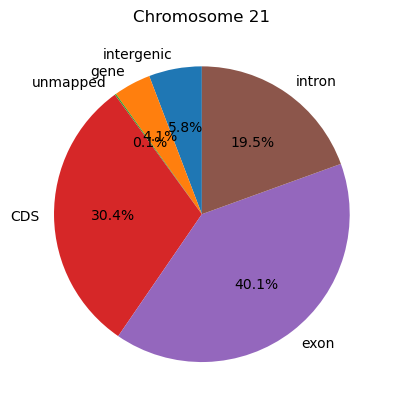

In [11]:
plot_region_counts(
    chromosome= 21,
    counts= counts
);

## Main function

	Loading reference genome...

	----> Processing chromosome 21...

	Calculating intergenic regions...

	Calculating intronic regions...

	Mapping mutations...

Mapping mutation 1/32215 ...
Mapping mutation 2/32215 ...
Mapping mutation 3/32215 ...
Mapping mutation 4/32215 ...
Mapping mutation 5/32215 ...
Mapping mutation 6/32215 ...
Mapping mutation 7/32215 ...
Mapping mutation 8/32215 ...
Mapping mutation 9/32215 ...
Mapping mutation 10/32215 ...
Mapping mutation 11/32215 ...
Mapping mutation 12/32215 ...
Mapping mutation 13/32215 ...
Mapping mutation 14/32215 ...
Mapping mutation 15/32215 ...
Mapping mutation 16/32215 ...
Mapping mutation 17/32215 ...
Mapping mutation 18/32215 ...
Mapping mutation 19/32215 ...
Mapping mutation 20/32215 ...
Mapping mutation 21/32215 ...
Mapping mutation 22/32215 ...
Mapping mutation 23/32215 ...
Mapping mutation 24/32215 ...
Mapping mutation 25/32215 ...
Mapping mutation 26/32215 ...
Mapping mutation 27/32215 ...
Mapping mutation 28/32215 ...
Mapping mu

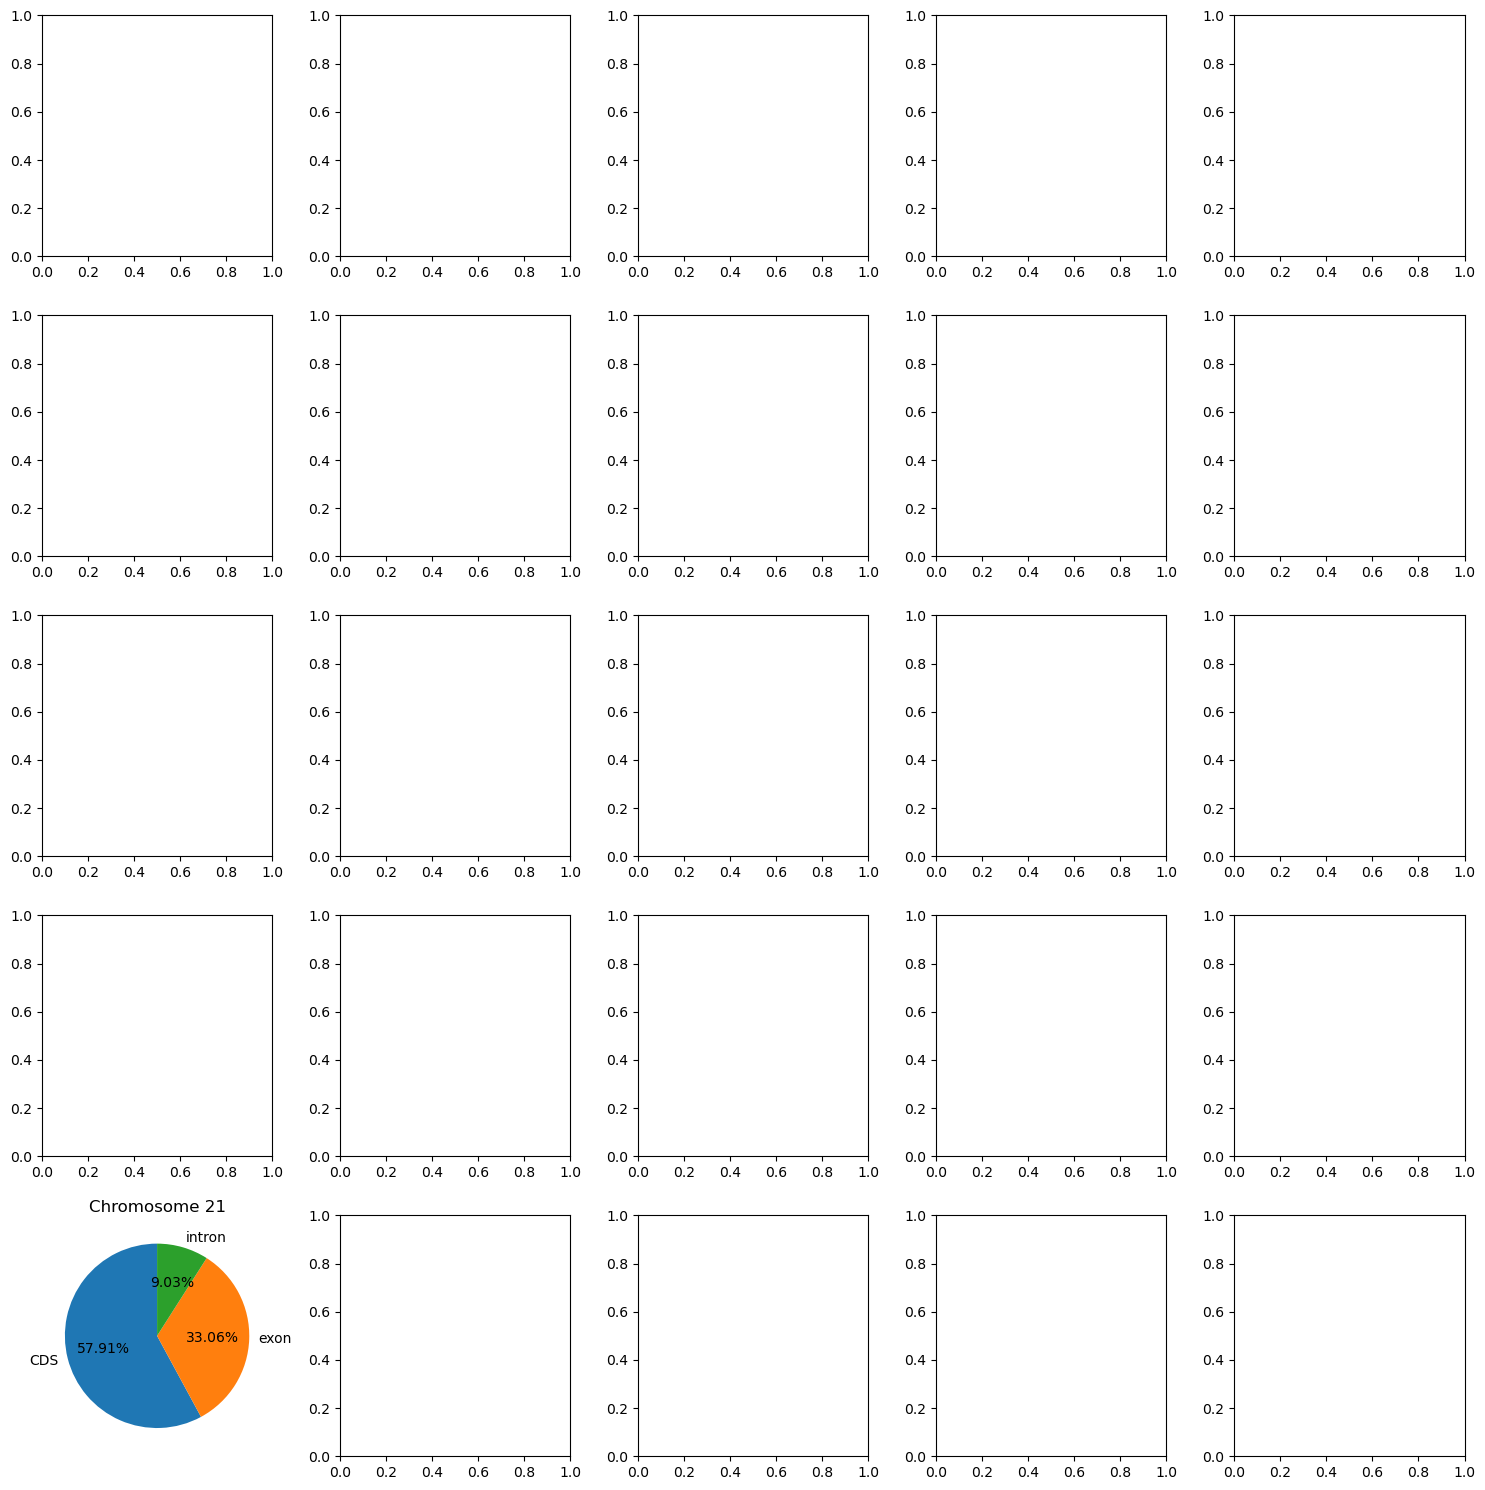

In [20]:
def get_genomic_regions(reference_genome: str, mutations: str, verbose= None):
    refseqs = {
        '1': 'NC_000001.11',
        '2': 'NC_000002.12',
        '3' : 'NC_000003.12',
        '4' : 'NC_000004.12',
        '5' : 'NC_000005.10',
        '6' : 'NC_000006.12',
        '7' : 'NC_000007.17',
        '8' : 'NC_000008.11',
        '9' : 'NC_000009.12',
        '10' : 'NC_000010.11',
        '11' : 'NC_000011.10',
        '12' : 'NC_000012.12',
        '13' : 'NC_000013.11',
        '14' :'NC_000014.9',
        '15' : 'NC_000015.10',
        '16' : 'NC_000016.10',
        '17' : 'NC_000017.11',
        '18' : 'NC_000018.10',
        '19' : 'NC_000019.10',
        '20' : 'NC_000020.11',
        '21' : 'NC_000021.9',
        '22' : 'NC_000022.11',
        'X' : 'NC_000023.11',
        'Y' : 'NC_000024.10',
        'MT' : 'NC_012920.1'
    }

    if verbose: 
        print('\tLoading reference genome...\n')
    gff_df = load_gff(reference_genome)
    mutations_df = load_vcf(mutations).sort_values(by=['pos']).reset_index(drop= True)

    fig, axs = plt.subplots(5, 5, figsize=(15, 15))

    for i, chr in enumerate(refseqs.keys()):
        if chr == '21':
            if verbose:
                print(f'\t----> Processing chromosome {chr}...\n')
            
            chr_gff = gff_df[gff_df["seqnames"] == refseqs[chr]]
            chr_mutations = mutations_df[mutations_df['seqnames'] == chr]
            mutations_positions = list(chr_mutations['pos'])

            # Filter only genes regions
            genes_df = chr_gff[chr_gff["feature"] == "gene"]
            genes_df = genes_df.sort_values(by=["starts", 'ends']).reset_index(drop= True)

            # Filter coding regions
            coding_df = chr_gff[(chr_gff["feature"] == "gene") | (chr_gff['feature'] == 'exon') | (chr_gff['feature'] == 'CDS')]

            # Get intergenic regions
            if verbose:
                print('\tCalculating intergenic regions...\n')
            intergenic_regions = get_intergenic_regions(genes_df= genes_df)
            temp_concatenated = pd.concat([coding_df, intergenic_regions], ignore_index=True).sort_values(by=["starts"]).reset_index(drop= True)

            # Get intronic regions
            if verbose:
                print('\tCalculating intronic regions...\n')
            intronic_regions = get_intron_regions(coding_df= temp_concatenated)
            concatenated_df = pd.concat([intronic_regions, temp_concatenated], ignore_index=True).sort_values(by=["starts", 'ends']).reset_index(drop= True)
            
            # Mapping regions
            counts = {
                'intergenic' : 0,
                'gene' : 0,
                'unmapped' : 0,
                'CDS' : 0,
                'exon' : 0,
                'intron' : 0
            }
            if verbose:
                print('\tMapping mutations...\n')
            for j, pos in enumerate(mutations_positions):
                if j <= 500:
                    if verbose:
                        print(f'Mapping mutation {j + 1}/{len(mutations_positions)} ...')
                    counts[binary_search(pos, concatenated_df)] += 1

            # Deletion of unnecessary objects
            if verbose:
                print('\tCollecting garbage...\n')
            del chr_gff
            del chr_mutations
            del genes_df
            del intergenic_regions
            del concatenated_df
            gc.collect()

            if verbose:
                print('\tPlotting counts...\n')
            # Plotting
            x = i // 5
            y = i  % 5
            plt.sca(axs[x, y])

            labels = counts.keys()
            sizes = counts.values()
            total = sum(counts.values())
            non_zero_sizes = [size for size in sizes if ((size * 100) / total) > 3]
            non_zero_labels = [label for label, size in zip(labels, sizes) if ((size * 100) / total) > 3]
            colors = cm.tab10.colors 
            plt.pie(
                non_zero_sizes,
                labels= non_zero_labels,
                colors= colors,
                autopct= '%1.2f%%',
                startangle= 90
            )
            plt.title(f'Chromosome {chr}')
            plt.tight_layout()

    return fig

# Ruta al archivo GTF
archivo_gtf = "./../data/GRCH38.p14_trimmed.gff"
archivo_vcf = './../data/clinvar_trimmed.vcf'
get_genomic_regions(
    reference_genome= archivo_gtf,
    mutations= archivo_vcf,
    verbose= True
).savefig(
    fname= './../results/prueba.png',
    transparent=True,
    bbox_inches='tight'
);
